# Gaussian Kernel Parameterization <a name="head"></a>

This is a tutorial to give an indication of how the Gaussian kernels works. A Gaussian process will be trained on a toy function and parameters explicitly varied to give a clear indication of their impact on the predicted function. The data is generated randomly, it may be beneficial to run through the notebook a number of times to see how the data generation impacts the predicted function.

The Gaussian kernel (also called Squared Exponential) is defined as follows:

$$
k \left( x,x' \right) = \sigma_{d}^{2} exp \left( -\frac{{ \left\| x-x' \right\|}^{ 2 }}
{2\ell^{ 2 }} \right) \label{equ.kernel}
$$

Where $x$ and $x'$ are feature vectors, $\sigma$ defines a scaling factor and $\ell$ the lengthscale.

## Table of Contents
[(Back to top)](#head)

-   [Data Setup](#data-setup)
-   [Lengthscale parameter](#lengthscale-parameter)
-   [Scaling parameter](#scaling-parameter)
-   [Regularization parameter](#regularization-parameter)
-   [Hyperparameter optimization](#hyperparameter-optimization)
-   [Conclusions](#conclusions)

## Data Setup <a name="data-setup"></a>
[(Back to top)](#head)

First, we define the necessary imports for the tutorial.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from catlearn.regression import GaussianProcess
from catlearn.regression.cost_function import get_error

We can set up a 2D-function to model with the following function.

In [2]:
def afunc(x):
    """Define some polynomial function."""
    y = x - 50.
    p = (y + 4) * (y + 4) * (y + 1) * (y - 1) * (y - 3.5) * (y - 2) * (y - 1)
    p += 40. * y + 80. * np.sin(10. * x)
    return 1. / 20. * p + 500

We can also define a plotting function at this stage.

In [3]:
def plot(sub, prediction):
    """Plotting function."""
    ax = fig.add_subplot(sub)
    ax.plot(linex, liney, '-', lw=1, color='black')
    ax.plot(train, target, 'o', alpha=0.5, color='black')
    ax.plot(test, prediction, 'r-', lw=1, alpha=0.8)
    plt.xlabel('Descriptor')
    plt.ylabel('Response')
    plt.axis('tight')

And then generate some training and testing data. Training the Gaussian process is performed with 17 data points, and a small amount of noise added. A far greater number of test data points are defined (513) in total. This provides a smooth predicted function so we can more clearly see what is happening with the predictions with a decent amount of detail.

In [4]:
# A number of training points in x.
train_points = 17
noise_magnitude = 1.

# Randomly generate the training datapoints x.
train = 7.6 * np.random.sample((train_points, 1)) - 4.2 + 50
# Each element in the list train can be referred to as a fingerprint.
# Call the underlying function to produce the target values.
target = np.array(afunc(train))

# Add random noise from a normal distribution to the target values.
target += noise_magnitude * np.random.randn(train_points, 1)

# Generate test datapoints x.
test_points = 513
test = np.vstack(np.linspace(np.min(train)-0.1, np.max(train)+0.1,
                             test_points))

# Store the known underlying function for plotting.
linex = np.linspace(np.min(test), np.max(test), test_points)
liney = afunc(linex)

## Lengthscale Parameter <a name="lengthscale-parameter"></a>
[(Back to top)](#head)

Next, we can then look at the effect of the lengthscale ($\ell$). The `scale_data` flag is set to true in the Gaussian process, so all the training and test features will be standardized (relative to only the train data). Therefore, we can expect the lengthscales to be reasonable in the range of `[1.5, 1., 0.5, 0.1]`. Changing these to larger/smaller values will give more extreme examples of the effect this parameter has on the Gaussian process.

Gaussian regression error with 1.5 width: 6.086
Gaussian regression error with 1.0 width: 3.290
Gaussian regression error with 0.5 width: 3.466
Gaussian regression error with 0.1 width: 6.654


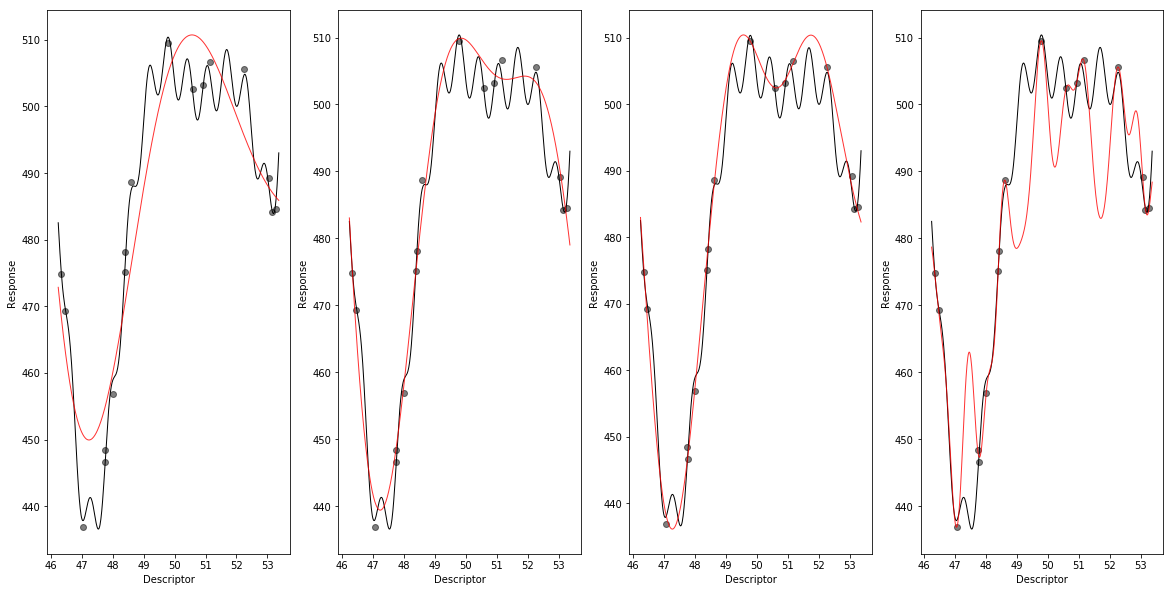

In [5]:
fig = plt.figure(figsize=(20, 10))

for w, p in zip([1.5, 1., 0.5, 0.1], [141, 142, 143, 144]):
    kdict = [{'type': 'gaussian', 'width': w, 'scaling': 1.}]
    # Set up the prediction routine.
    gp = GaussianProcess(kernel_list=kdict, regularization=np.sqrt(1e-3),
                         train_fp=train,
                         train_target=target,
                         optimize_hyperparameters=False, scale_data=True)
    # Do predictions.
    fit = gp.predict(test_fp=test)

    # Get average errors.
    error = get_error(fit['prediction'], afunc(test))
    print('Gaussian regression error with {0} width: {1:.3f}'.format(
        w, error['absolute_average']))

    # Plotting.
    plot(p, fit['prediction'])

## Scaling Parameter <a name="scaling-parameter"></a>
[(Back to top)](#head)

And then the same study can be performed with the scaling parameter ($\sigma$).

Gaussian regression error with 1.0 regularization: 3.466
Gaussian regression error with 100.0 regularization: 3.844
Gaussian regression error with 10000.0 regularization: 4.157
Gaussian regression error with 1000000.0 regularization: 4.591


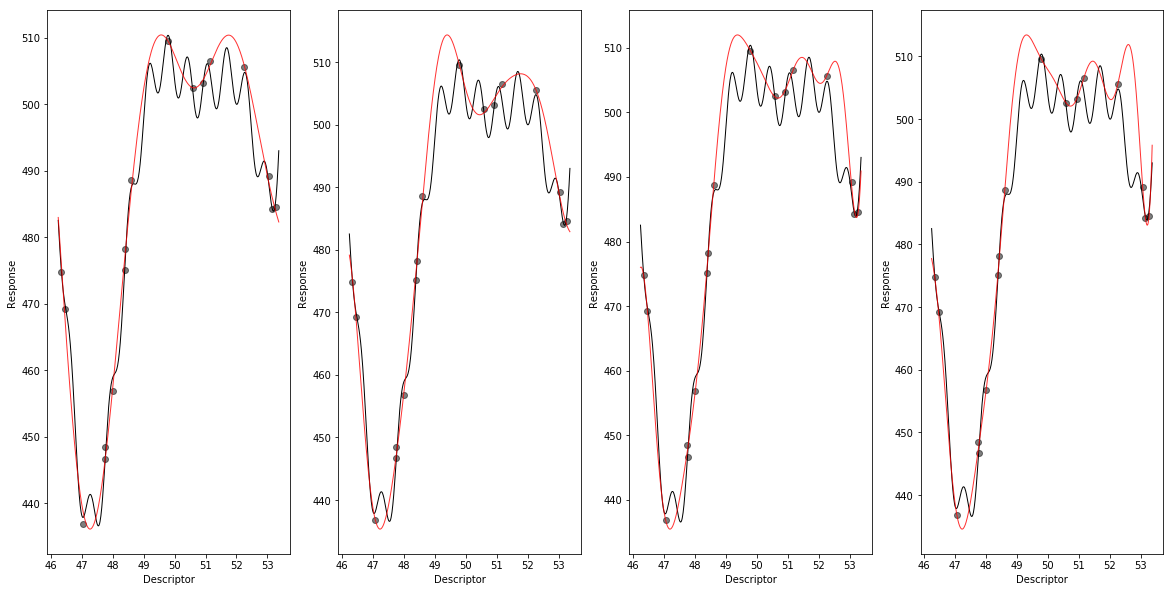

In [6]:
fig = plt.figure(figsize=(20, 10))

for s, p in zip([1., 1e2, 1e4, 1e6], [141, 142, 143, 144]):
    kdict = [{'type': 'gaussian', 'width': 0.5, 'scaling': s}]
    # Set up the prediction routine.
    gp = GaussianProcess(kernel_list=kdict, regularization=np.sqrt(1e-3),
                         train_fp=train,
                         train_target=target,
                         optimize_hyperparameters=False, scale_data=True)
    # Do predictions.
    fit = gp.predict(test_fp=test)

    # Get average errors.
    error = get_error(fit['prediction'], afunc(test))
    print('Gaussian regression error with {0} regularization: {1:.3f}'.format(
        s, error['absolute_average']))

    # Plotting.
    plot(p, fit['prediction'])

## Regularization Parameter <a name="regularization-parameter"></a>
[(Back to top)](#head)

Next, we can do the same with regularization, here we iterate over the `[1., 1e-2, 1e-4, 1e-6]` vector. This once again gives a reasonable spread for the regularization. Once again, changing these to larger/smaller values will give more extreme examples of the effect this parameter has on the Gaussian process.

Gaussian regression error with 1.0 regularization: 6.887
Gaussian regression error with 0.1 regularization: 3.231
Gaussian regression error with 0.01 regularization: 3.600
Gaussian regression error with 0.001 regularization: 4.028


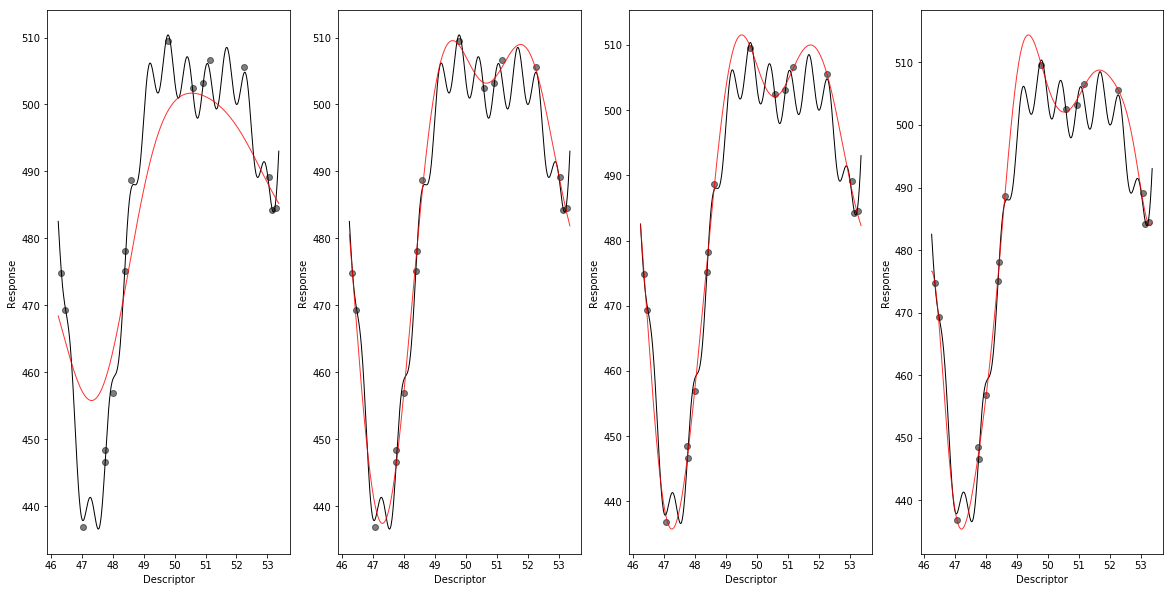

In [7]:
fig = plt.figure(figsize=(20, 10))

for r, p in zip([1., 1e-1, 1e-2, 1e-3], [141, 142, 143, 144]):
    kdict = [{'type': 'gaussian', 'width': 0.5, 'scaling': 1.}]
    # Set up the prediction routine.
    gp = GaussianProcess(kernel_list=kdict, regularization=r,
                         train_fp=train,
                         train_target=target,
                         optimize_hyperparameters=False, scale_data=True)
    # Do predictions.
    fit = gp.predict(test_fp=test)

    # Get average errors.
    error = get_error(fit['prediction'], afunc(test))
    print('Gaussian regression error with {0} regularization: {1:.3f}'.format(
        r, error['absolute_average']))

    # Plotting.
    plot(p, fit['prediction'])

## Hyperparameter optimization <a name="hyperparameter-optimization"></a>
[(Back to top)](#head)

This is really just to give a sense of the impact of changing the parameters on the prediction. In reality, we will use some automated hyperparameter optimization. This optimization is performed in the following resulting in what should be an optimal Gaussian process for the data available. In this case, the log-marginal likelihood is used to find a balance between over and under-fitting. Thus, the Gaussian process trained with the optimized hyperparameters may not give the smallest error.

Gaussian regression error: 3.360
Optimized width: 0.451
Optimized scale: 1.586
Optimized regularization: 0.084


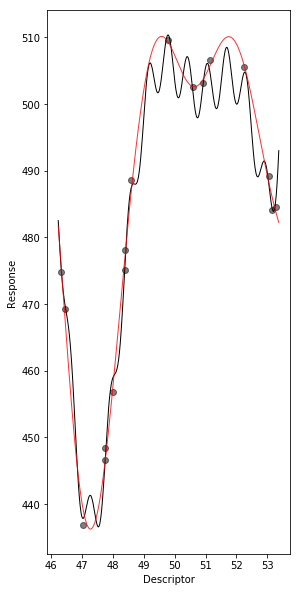

In [8]:
fig = plt.figure(figsize=(20, 10))

kdict = [{'type': 'gaussian', 'width': 0.5, 'scaling': 1.}]
# Set up the prediction routine.
gp = GaussianProcess(kernel_list=kdict, regularization=np.sqrt(1e-3),
                     train_fp=train,
                     train_target=target,
                     optimize_hyperparameters=True, scale_data=True)
# Do predictions.
fit = gp.predict(test_fp=test)

# Get average errors.
error = get_error(fit['prediction'], afunc(test))
print('Gaussian regression error: {0:.3f}'.format(
    error['absolute_average']))

# Plotting.
plot(p, fit['prediction'])

print('Optimized width: {0:.3f}'.format(gp.kernel_list[0]['width'][0]))
print('Optimized scale: {0:.3f}'.format(gp.kernel_list[0]['scaling']))
print('Optimized regularization: {0:.3f}'.format(gp.regularization))

## Conclusions <a name="conclusions"></a>
[(Back to top)](#head)

Here we have stepped through a number of parameters for the Gaussian kernel. It is possible to see how functions become underfit or overfit by the Gaussian process. In reality, we will usually use the hyperparameter optimization via the log-marginal likelihood. This will not always give us the lowest error, however, it will give the best approximation for the available data, avoiding overfitting.